<h1><center><font size="6">Automated Hate Tweet Detection</font></center></h1>

Contents:

- Introduction:
- Business Understanding:
- Data Sources:
    - Importing Packages
    - Original Dataset
- Data Understanding:
    - EDA and Feature Engineering
        - Word Count Per Tweet
        - Number of Characters Per tweet
        - Avereage Word Length Per Tweet
        - Hashtags Count 
- Data Preprocessing:
    - Preprocessing Function and Feature Engineering
    - Assigning Target Variable
    - Train-Validation-Test Split
    - Separate into Classes
    - Frequency Distributions
    - TSNE
    - WordCloud
    - Bigrams
    - Term Freqeuncy
- Modeling and Evaluation Process:
    - Multinomial Naive Bayes
    - Random Forest
    - Logistic Regression
    - Support Vector Machine
    - Adaboost Classifier
    - Gradient Boost Classifier
- Class Imbalance:
    - Resampling Methods
        - RandomUnderSampler
        - CondensedNearestNeighbour
        - SMOTE-ENN
    - Additional Datasets
        - Aristotle University Dataset
        - Twitter API
        - University of Copenhagen Dataset
        - HASOC 2019 and 2020 Dataset
    - Validation-Test Split
- Evaluation

# Introduction and Business Understanding:

Why should we care about regulating or detecting hate speech in the first place?  All democracies are in agreement that hate speech that incites violence or harm towards another group should be prohibited.  For Americans, who believe in the fundamental right to freedom of speech as afforded by the Constitution, regulating hate speech that is degrading of groups of people has not been and cannot be regulated. A recent NYU study from 2019 has found a direct link between the number of racist tweets and real-life hate crimes in 100 US cities, and Twitter has been hugely criticized for being complacent in curbing hate speech on their platform.  Democracies around the world take much more stringent measures against curbing hate speech than the United States because laws criminalizing such speech would violate the guarantee to the rights afforded to its citizens by the 1st Amendment.  Recent events have demonstrated how words have the power to incite others violence, namely the insurrection against one of our own institutions at the Capital on January 6th.  We have also seen the recent rise in Asian-American hate crime throughout the nation culminating in the Atlanta shooting due to the incessant invocation of words associating COVID with China like "Kung-flu" or "Chinavirus" by our top officials.

A key challenge in the automated detection of hate speech is differentiating between hate speech and offensive language. Hate speech is defined as public speech that expresses hate, disparages, or incites or encourages violence against another individual or group based on some characteristic such as race, gender, religious belief, sexual orientation, etc.  Even that exact definition can differ from region to region or country to country.  It is essential that we recognize that even the same hate or derogatory word can have or  and definitely from context to context. Even the ever-pervasive 4 letter f-word easily demonstrates this ambiguity:  "f@!k the (insert ethnic group), they need to go back where they came from" vs. "fuck my life and everyone in it, i work so hard but get no where. #f@!&mylife". In the former, the word is used to express hate towards an ethnic group, but in the latter, it is more of an expression of when things don't go right or how you would have expected it to.  If you look at the word f****t,the derogatory term for homosexuals, reclaiming the word from its more negative connotation into an expression of playfulness even pride has been an important step in their personal identity journey.

Sparked by the alarming nature of recent events, social media platforms have already implemented algorithms to regulate or remove hate tweets, and having the ability to differentiate between hate versus non-hate is an integral part of any model.

# Data Sources:

I started with the Davidson dataset because 

## Importing Packages

In [2]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import re as regex
import pickle
import datetime
import plotly
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from plotly import graph_objs
import plotly.graph_objs as go
import chart_studio.plotly as py
plotly.offline.init_notebook_mode()
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text.tsne import tsne
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob, Word

from sklearn import linear_model, utils, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours, RandomUnderSampler, TomekLinks, CondensedNearestNeighbour
from imblearn.combine import SMOTETomek, SMOTEENN


import multiprocessing
from gensim.models.doc2vec import TaggedDocument, LabeledSentence
from gensim.models import Word2Vec, Doc2Vec

%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("py/")
from utils import *
from config import keys
from preprocess import *

## Original Davidson Dataset


In [3]:
# read in 
df = pd.read_csv("data/labeled_data.csv", index_col=0)
df.head()

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [4]:
df.shape

(24783, 6)

In [5]:
df = df.rename(columns={"hate_speech": 'hate', "offensive_language": 'offensive', "neither": 'neutral', "class": 'target'})
df.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [6]:
hate = len(df[df['target'] == 0])
off = len(df[df['target'] == 1])
neu = len(df[df['target'] == 2])
dist = [
    graph_objs.Bar(
        x=["hate", "offensive", "neutral"],
        y=[hate, off, neu],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Class Distribution")})

In [7]:
df2 = df.copy()
df2.target = df2.target.replace([2], 1)
df2.target = df2.target.replace([0, 1], [1, 0])
df2.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

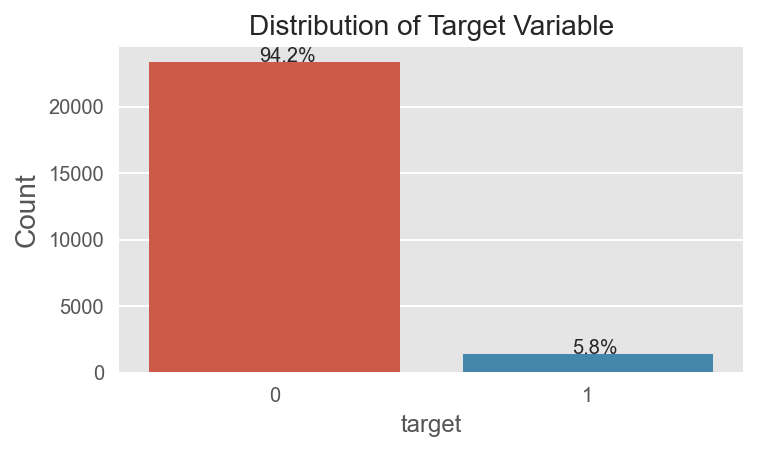

In [8]:
# create visualization for target variable distribution
def barplot(df, feature, title):
    plt.figure(figsize = (5,3))
    ax = sns.countplot(x = feature, data = df)
    plt.title(title, fontsize = 14)
    plt.ylabel("Count", fontsize = 14)
    total = len(df.target)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 10)
    plt.show()

plt.style.use("ggplot")
barplot(df2, 'target', 'Distribution of Target Variable')

# Data Understanding:

## EDA and Feature Engineering

In [9]:
df.tweet.head(30)

0     !!! RT @mayasolovely: As a woman you shouldn't...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

## Word Count Per Tweet

In [10]:
def num_of_words(df, col):
    df['word_ct'] = df[col].apply(lambda x: len(str(x).split(" ")))
    print(df[[col, 'word_ct']])

num_of_words(df, 'tweet')

                                                   tweet  word_ct
0      !!! RT @mayasolovely: As a woman you shouldn't...       25
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26
...                                                  ...      ...
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...       19
25292  you've gone and broke the wrong heart baby, an...       13
25294  young buck wanna eat!!.. dat nigguh like I ain...       13
25295              youu got wild bitches tellin you lies        7
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...       18

[24783 rows x 2 columns]


In [11]:
df['word_ct'].iplot(
    kind='hist',
    bins=40,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution')

## Number of Characters Per Tweet

In [12]:
def num_of_chars(df, col):
    df['char_ct'] = df[col].str.len()
    print(df[[col, 'char_ct']])

num_of_chars(df, 'tweet')

                                                   tweet  char_ct
0      !!! RT @mayasolovely: As a woman you shouldn't...      140
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       85
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      120
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...       62
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      137
...                                                  ...      ...
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...      146
25292  you've gone and broke the wrong heart baby, an...       70
25294  young buck wanna eat!!.. dat nigguh like I ain...       67
25295              youu got wild bitches tellin you lies       37
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      127

[24783 rows x 2 columns]


In [13]:
df['char_ct'].iplot(
    kind='hist',
    bins=100,
    xTitle='character count',
    linecolor='black',
    yTitle='count',
    title='Character Count Distribution')

## Average Word Length Per Tweet

In [14]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def avg_word_length(df, col):
    df['avg_wrd'] = df[col].apply(lambda x: avg_word(x))
    print(df[[col, 'avg_wrd']].head())

avg_word_length(df, 'tweet')

                                               tweet   avg_wrd
0  !!! RT @mayasolovely: As a woman you shouldn't...  4.640000
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  4.375000
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  4.761905
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  6.000000
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  4.307692


In [15]:
df['avg_wrd'].iplot(
    kind='hist',
    bins=60,
    xTitle='average word length',
    linecolor='black',
    yTitle='count',
    title='Average Word Length Distribution')

## Hashtags Count

In [16]:
def hash_ct(df, col):
    df['hash_ct'] = df[col].apply(lambda x: len(re.split(r'#', str(x)))-1)
    print(df[[col, 'hash_ct']].head())

hash_ct(df, 'tweet')

                                               tweet  hash_ct
0  !!! RT @mayasolovely: As a woman you shouldn't...        0
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...        0
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...        0
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        0
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...        1


In [17]:
df['hash_ct'].iplot(
    kind='hist',
    bins=100,
    xTitle='hashtags count',
    linecolor='black',
    yTitle='count',
    title='Number of Hashtags Distribution')

# Data Preprocessing:

What are the challenges in dealing with tweets:

1) Inconsistent use of grammar, proper spelling, punctuation, and capitalization
2) Repetition of same ch1aracter, and use of random abbreviations makes tokenization and POS tagging difficult

2) Use of special characters, i.e. emojis, emoticons, hashtags, 

## Preprocessing Function and Feature Engineering

- Letter casing: Converting all letters to either upper case or lower case.
- Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text.
- Noise removal: Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces etc.
- Stopword removal: Some words do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords can be defined by the nltk library, or it can be business-specific.
- Normalization: Normalization generally refers to a series of related tasks meant to put all text on the same level. Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies. Normalization improves text matching.
- Stemming: Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. Porter Stemmer is the most widely used technique because it is very fast. Generally, stemming chops off end of the word, and mostly it works fine. Example: Working -> Work
- Lemmatization: The goal is same as with stemming, but stemming a word sometimes loses the actual meaning of the word. Lemmatization usually refers to doing things properly using vocabulary and morphological analysis of words. It returns the base or dictionary form of a word, also known as the lemma. Example: Better -> Good.
    - Stemming is faster than lemmatization. You can uncomment the code and see how results change. Note: Do not apply both. Remember that stemming and lemmatization are normalization techniques, and it is recommended to use only one approach to normalize. Let your project requirements guide your decision, or you can always do experiments and see which one gives better results. In this case, stemming and lemmatizing yield almost the same accuracy.
- Vectorizing Data: Vectorizing is the process to convert tokens to numbers. It is an important step because the machine learning algorithm works with numbers and not text, such as vectorization using tf-idf, or Bag of Words and N-grams.

In [18]:
def preprocess_tweets(df, col):
    """master function to preprocess tweets"""
    collect_and_remove_users(df, col)
    collect_and_remove_charef(df, col)
    collect_and_remove_hashtags(df, col)
    remove_links(df, col)
    remove_av_qt(df, col)
    remove_punctuation(df, col)
    lowercasing(df, col)
    remove_whitespaces(df, col)
    remove_numerics(df, col)
    tokenize_and_lemmatize(df, col)

preprocess_tweets(df, 'tweet')

In [19]:
df.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  word_ct  char_ct  \
0  [woman, shouldnt, complain, clean, house, man,...       25      140   
1  [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...       16       85   
2          [dawg, fuck, bitch, start, confuse, shit]       21      120   
3                               [look, like, tranny]        9       62   
4             [shit, hear, true, faker, bitch, tell]       26      137   

    avg_wrd  hash_ct              retweets         callouts     charref  \
0  4.640000        0    'RT @mayasolovely'                      '&amp;'   
1  4.375000        0         'RT @mleew17'                                
2  4.761905        0   'RT @UrKindOfBrand'  '@80sbaby4life'               
3  6.000000        0    'RT @C_G_Anderson'    '@viva_based'               
4  4.307692        1  'RT @ShenikaRoberts'                   '&#57361;'   

  hashtags  
0           
1           
2           
3           
4

In [28]:
#df.to_excel(r'/Volumes/My Passport for Mac/Dropbox/Data Science/VSCode/Repositories/Automated-Hate-Tweet-Detection/data/tableau.xlsx', index=False)

## Assigning Target Variable

In [29]:
df2 = df.copy()

In [30]:
df2['target'].value_counts()

1    19190
2     4163
0     1430
Name: target, dtype: int64

In [31]:
df2['target'] = df2['target'].replace([2], 1)
df2['target'].value_counts()

1    23353
0     1430
Name: target, dtype: int64

In [32]:
df2.target = df2.target.replace([0, 1], [1, 0])
df2.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

In [33]:
df2.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       0   
1      3     0          3        0       0   
2      3     0          3        0       0   
3      3     0          2        1       0   
4      6     0          6        0       0   

                                               tweet  word_ct  char_ct  \
0  [woman, shouldnt, complain, clean, house, man,...       25      140   
1  [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...       16       85   
2          [dawg, fuck, bitch, start, confuse, shit]       21      120   
3                               [look, like, tranny]        9       62   
4             [shit, hear, true, faker, bitch, tell]       26      137   

    avg_wrd  hash_ct              retweets         callouts     charref  \
0  4.640000        0    'RT @mayasolovely'                      '&amp;'   
1  4.375000        0         'RT @mleew17'                                
2  4.761905        0   'RT @UrKindOfBrand'  '@80sbaby4life'               
3  6.000000        0    'RT @C_G_Anderson'    '@viva_based'               
4  4.307692        1  'RT @ShenikaRoberts'                   '&#57361;'   

  hashtags  
0           
1           
2           
3           
4

In [34]:
df2.to_excel(r'/Volumes/My Passport for Mac/Dropbox/Data Science/VSCode/Repositories/Automated-Hate-Tweet-Detection/data/tableau2.xlsx', index=False)

In [35]:
hate = df2[df2.target == 1]
non_hate = df2[df2.target == 0]

## Train-Validation-Test Split

In [36]:
X_h = hate.tweet
y_h = hate.target
X_nh = non_hate.tweet
y_nh = non_hate.target

X_h_tr, X_h_val, y_h_tr, y_h_val = train_test_split(X_h, y_h, test_size=0.25, random_state=42)
X_h_val, X_h_tt, y_h_val, y_h_tt = train_test_split(X_h_val, y_h_val, test_size=0.4, random_state=42)
X_nh_tr, X_nh_val, y_nh_tr, y_nh_val = train_test_split(X_nh, y_nh, test_size=0.25, random_state=42)
X_nh_val, X_nh_tt, y_nh_val, y_nh_tt = train_test_split(X_nh_val, y_nh_val, test_size=0.4, random_state=42)

In [63]:
X_tr = pd.concat((X_h_tr, X_nh_tr), ignore_index=True)
y_tr = pd.concat((y_h_tr, y_nh_tr), ignore_index=True)
train = pd.concat([X_tr, y_tr], axis=1)
train['tweet2'] = train.tweet.apply(lambda x: str(x)[1:-1]) 
train.head()

tweet  target  \
0  [reject, constantly, house, threaten, rape, mo...       1   
1  [convince, lame, nigger, liver, believe, cuz, ...       1   
2  [peace, fag, remember, best, lux, support, dro...       1   
3                    [haha, ight, nig, calm, yoself]       1   
4  [tits, better, look, face, make, like, asian, ...       1   

                                              tweet2  
0  'reject', 'constantly', 'house', 'threaten', '...  
1  'convince', 'lame', 'nigger', 'liver', 'believ...  
2  'peace', 'fag', 'remember', 'best', 'lux', 'su...  
3            'haha', 'ight', 'nig', 'calm', 'yoself'  
4  'tits', 'better', 'look', 'face', 'make', 'lik...

In [64]:
X_val = pd.concat((X_h_val, X_nh_val), ignore_index=True)
y_val = pd.concat((y_h_val, y_nh_val), ignore_index=True)
val = pd.concat([X_val, y_val], axis=1)
val['tweet2'] = val.tweet.apply(lambda x: str(x)[1:-1]) 
val.head()

tweet  target  \
0  [lbum, fotos, gaywrites, make, project, queer,...       1   
1  [yay, america, israel, jew, hat, muslim, trash...       1   
2  [miss, ofay, friends, day, scar, recent, happe...       1   
3     [trash, darkskin, nigga, steal, damn, garbage]       1   
4      [cody, call, people, nigger, hes, fuck, spaz]       1   

                                              tweet2  
0  'lbum', 'fotos', 'gaywrites', 'make', 'project...  
1  'yay', 'america', 'israel', 'jew', 'hat', 'mus...  
2  'miss', 'ofay', 'friends', 'day', 'scar', 'rec...  
3  'trash', 'darkskin', 'nigga', 'steal', 'damn',...  
4  'cody', 'call', 'people', 'nigger', 'hes', 'fu...

In [65]:
X_tt = pd.concat((X_h_tt, X_nh_tt), ignore_index=True)
y_tt = pd.concat((y_h_tt, y_nh_tt), ignore_index=True)
test = pd.concat([X_tt, y_tt], axis=1)
test.head()

tweet  target
0                       [johnny, rebel, nigger, day]       1
1  [favorite, nigger, work, plantation, remember,...       1
2  [go, prestigious, establishments, clearly, sup...       1
3                       [westvirginia, white, trash]       1
4  [fuck, brett, farve, redneck, ass, stuckup, do...       1

## Separate into classes

In [66]:
zero = train[train.target == 0]
zero.head()

tweet  target  \
1072                                            [bitch]       0   
1073                 [take, bitch, months, scarf, smfh]       0   
1074  [kim, alright, honestly, niggas, miley, get, u...       0   
1075  [bitch, worry, fin, fuck, best, friend, get, j...       0   
1076  [end, ordination, women, faggot, aim, weaken, ...       0   

                                                 tweet2  
1072                                            'bitch'  
1073         'take', 'bitch', 'months', 'scarf', 'smfh'  
1074  'kim', 'alright', 'honestly', 'niggas', 'miley...  
1075  'bitch', 'worry', 'fin', 'fuck', 'best', 'frie...  
1076  'end', 'ordination', 'women', 'faggot', 'aim',...

In [67]:
one = train[train.target == 1]
one.head()

tweet  target  \
0  [reject, constantly, house, threaten, rape, mo...       1   
1  [convince, lame, nigger, liver, believe, cuz, ...       1   
2  [peace, fag, remember, best, lux, support, dro...       1   
3                    [haha, ight, nig, calm, yoself]       1   
4  [tits, better, look, face, make, like, asian, ...       1   

                                              tweet2  
0  'reject', 'constantly', 'house', 'threaten', '...  
1  'convince', 'lame', 'nigger', 'liver', 'believ...  
2  'peace', 'fag', 'remember', 'best', 'lux', 'su...  
3            'haha', 'ight', 'nig', 'calm', 'yoself'  
4  'tits', 'better', 'look', 'face', 'make', 'lik...

## Frequency Distributions

FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['aaahhhhh', 'aahahah', 'aaliyah', 'aamu', 'aan',
                              'aap', 'aaron', 'abandonado', 'abbey', 'abby',
                              'abc', 'abdelka', 'abduction', 'abdullah', 'abed',
                              'aberdeen', 'ability', 'able', 'abo', 'abort',
                              'abortion', 'abou', 'abound', 'abraham', 'abs',
                              'absent', 'absolute', 'absolutely',
                              'absoluteyvile', 'abstract', ...],
                    n=None, orient='v')

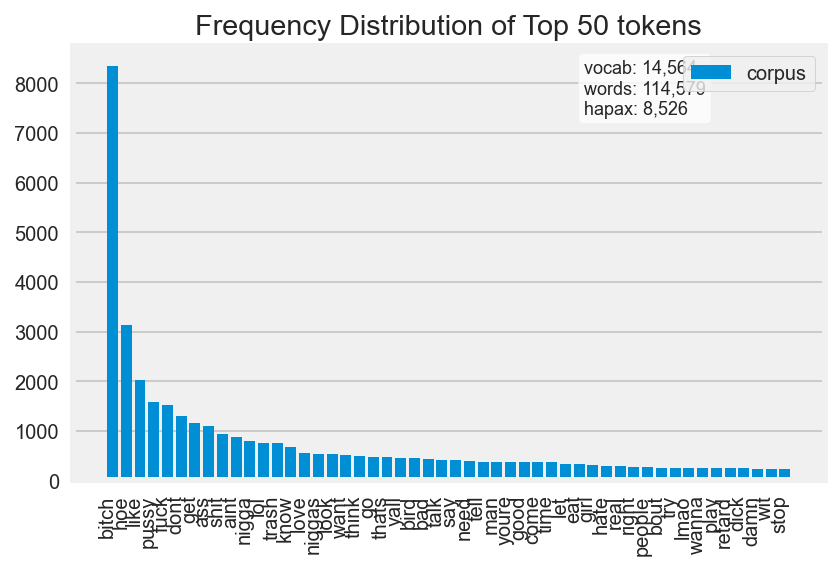

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [68]:
vec = CountVectorizer()
zero_tokens = zero.tweet.sum()
docs = vec.fit_transform(zero_tokens)
features = vec.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['aap', 'absolve', 'abuse', 'accept', 'acceptable',
                              'accord', 'account', 'accuracy', 'act', 'actin',
                              'active', 'activities', 'activity', 'actual',
                              'actually', 'add', 'address', 'admit', 'ads',
                              'advice', 'affection', 'afford', 'aflcio',
                              'africa', 'african', 'age', 'agg', 'ago', 'agree',
                              'ahh', ...],
                    n=None, orient='v')

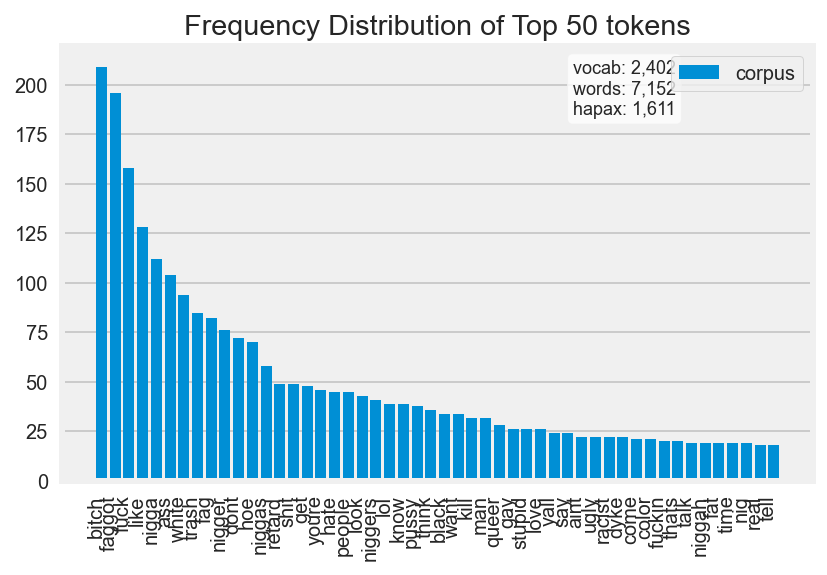

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [69]:
vec = CountVectorizer()
one_tokens = one.tweet.sum()
docs = vec.fit_transform(one_tokens)
features = vec.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

## TSNE

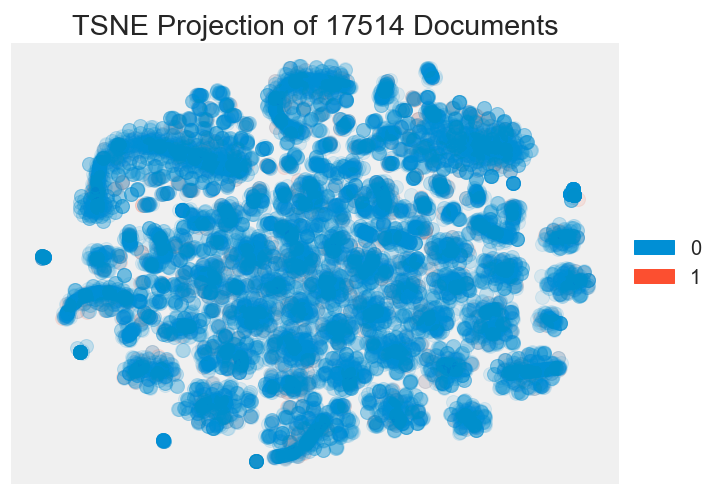

TSNEVisualizer(alpha=0.1,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 17514 Documents'}>,
               decompose=None, decompose_by=None)

In [70]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(zero.tweet2)
y = train.target

tsne(X, y, alpha=0.1, decompose='svd')

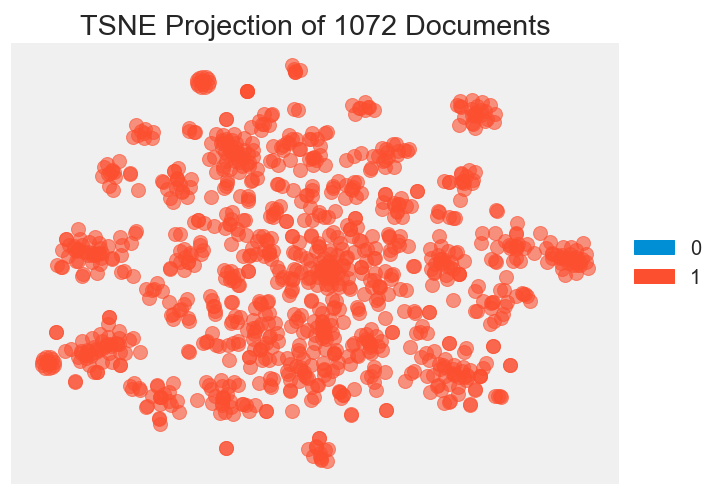

TSNEVisualizer(alpha=0.6,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 1072 Documents'}>,
               decompose=None, decompose_by=None)

In [71]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(one.tweet2)
y = train.target

tsne(X, y, alpha=0.6, decompose='svd')

## Wordcloud

(-0.5, 399.5, 199.5, -0.5)

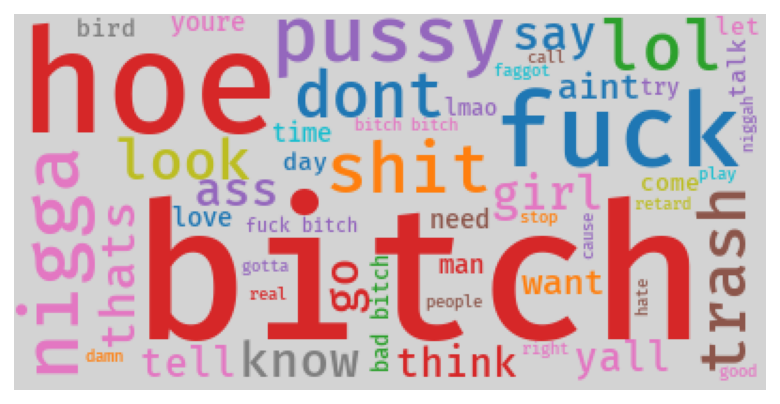

In [72]:
text = ' '.join(zero_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

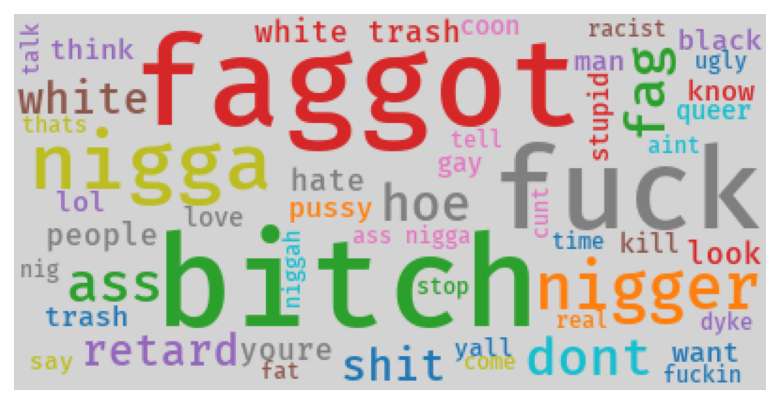

In [73]:
text = ' '.join(one_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

## Bigrams

In [74]:
def combination_of_words(df):
    return TextBlob(" ".join(train.tweet.sum())).ngrams(2)

combination_of_words(zero)[:20]

[WordList(['reject', 'constantly']),
 WordList(['constantly', 'house']),
 WordList(['house', 'threaten']),
 WordList(['threaten', 'rape']),
 WordList(['rape', 'mom']),
 WordList(['mom', 'karmas']),
 WordList(['karmas', 'bitch']),
 WordList(['bitch', 'rot']),
 WordList(['rot', 'hell']),
 WordList(['hell', 'faggot']),
 WordList(['faggot', 'convince']),
 WordList(['convince', 'lame']),
 WordList(['lame', 'nigger']),
 WordList(['nigger', 'liver']),
 WordList(['liver', 'believe']),
 WordList(['believe', 'cuz']),
 WordList(['cuz', 'nigger']),
 WordList(['nigger', 'whore']),
 WordList(['whore', 'peace']),
 WordList(['peace', 'fag'])]

In [75]:
combination_of_words(one)[:20]

[WordList(['reject', 'constantly']),
 WordList(['constantly', 'house']),
 WordList(['house', 'threaten']),
 WordList(['threaten', 'rape']),
 WordList(['rape', 'mom']),
 WordList(['mom', 'karmas']),
 WordList(['karmas', 'bitch']),
 WordList(['bitch', 'rot']),
 WordList(['rot', 'hell']),
 WordList(['hell', 'faggot']),
 WordList(['faggot', 'convince']),
 WordList(['convince', 'lame']),
 WordList(['lame', 'nigger']),
 WordList(['nigger', 'liver']),
 WordList(['liver', 'believe']),
 WordList(['believe', 'cuz']),
 WordList(['cuz', 'nigger']),
 WordList(['nigger', 'whore']),
 WordList(['whore', 'peace']),
 WordList(['peace', 'fag'])]

## Term Frequency



In [77]:
def term_frequency(df):
    tf1 = (df['tweet2'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
    tf1.columns = ['words', 'tf']
    tf1 = tf1.sort_values(by='tf', ascending=False).reset_index()
    return tf1

tf1 = term_frequency(zero)
tf1.head(10)

index     words      tf
0      4  'bitch',  6151.0
1      0   'bitch'  2190.0
2     83    'hoe',  2185.0
3     76   'like',  1885.0
4     17   'fuck',  1396.0
5     90   'dont',  1277.0
6     74  'pussy',  1179.0
7      7    'get',  1130.0
8    138    'ass',   975.0
9     93     'hoe'   945.0

In [78]:
tf2 = term_frequency(one)
tf2.head(10)

index      words     tf
0      3   'bitch',  159.0
1     53    'fuck',  153.0
2     34    'like',  119.0
3    125  'faggot',  105.0
4     64   'white',   93.0
5     72     'ass',   93.0
6     10   'faggot'   91.0
7     88   'nigga',   87.0
8    340    'dont',   72.0
9    444   'trash',   55.0

# Modeling Process:

In [103]:
X_tr = train.tweet2
X_val = val.tweet2
y_tr = train.target
y_val = val.target
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes

In [104]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metriks(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)


Train Accuracy:  0.9425373937372216
Val Accuracy:  0.9426957223567393
Train F1:  0.007434944237918215
Val F1:  0.009302325581395347
Train Recall:  0.0037313432835820895
Val Recall:  0.004672897196261682
Train Precision:  1.0
Val Precision:  1.0
Train PR-AUC:  0.304957716674489
Val PR-AUC:  0.17675788857212738


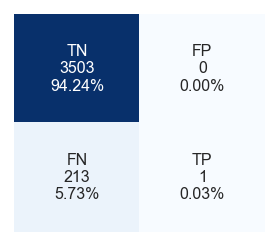

In [105]:
get_confusion(y_val, y_pr_nb_val)

## Random Forest

In [106]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metriks(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)

Train Accuracy:  0.9975788227698268
Val Accuracy:  0.9418886198547215
Train F1:  0.9789621318373072
Val F1:  0.16279069767441862
Train Recall:  0.976679104477612
Val Recall:  0.09813084112149532
Train Precision:  0.9812558575445174
Val Precision:  0.4772727272727273
Train PR-AUC:  0.9922967707673661
Val PR-AUC:  0.32473937332766595


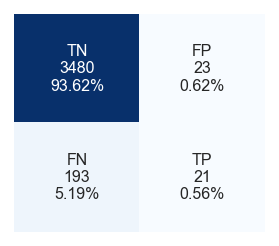

In [107]:
get_confusion(y_val, y_pr_rf_val)

## Logistic Regression

In [108]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metriks(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

Train Accuracy:  0.9470569245668783
Val Accuracy:  0.9443099273607748
Train F1:  0.22151898734177214
Val F1:  0.20077220077220076
Train Recall:  0.13059701492537312
Val Recall:  0.12149532710280374
Train Precision:  0.7291666666666666
Val Precision:  0.5777777777777777
Train PR-AUC:  0.5666932304076191
Val PR-AUC:  0.355640424831512


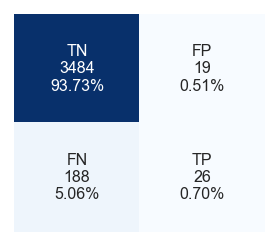

In [109]:
get_confusion(y_val, y_pr_log_val)

## SVM

In [110]:
svc = svm.LinearSVC(random_state=42).fit(tfidf_tr, y_tr)
y_pr_svc_tr = svc.predict(tfidf_tr)
y_pr_svc_val = svc.predict(tfidf_val)
get_metriks_2(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_svc_tr, y_pr_svc_val, svc)

Train Accuracy:  0.97697191434413
Val Accuracy:  0.9391982781813291
Train F1:  0.767643865363735
Val F1:  0.2709677419354839
Train Recall:  0.6595149253731343
Val Recall:  0.19626168224299065
Train Precision:  0.9181818181818182
Val Precision:  0.4375
Train PR-AUC:  0.8656932991178676
Val PR-AUC:  0.32508683821796447


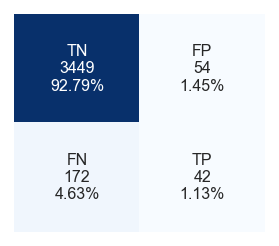

In [111]:
get_confusion(y_val, y_pr_svc_val)

## Adaboost

In [112]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
    ).fit(tfidf_tr, y_tr)
y_pr_ada_tr = abc.predict(tfidf_tr)
y_pr_ada_val = abc.predict(tfidf_val)
get_metriks(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_ada_tr, y_pr_ada_val, abc)

Train Accuracy:  0.9485634348434305
Val Accuracy:  0.9405434490180253
Train F1:  0.36939313984168864
Val F1:  0.2706270627062706
Train Recall:  0.26119402985074625
Val Recall:  0.19158878504672897
Train Precision:  0.6306306306306306
Val Precision:  0.4606741573033708
Train PR-AUC:  0.5451354775395658
Val PR-AUC:  0.2932854372543028


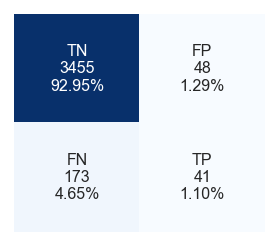

In [113]:
get_confusion(y_val, y_pr_ada_val)

## Gradient Boosting

In [114]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier().fit(tfidf_tr, y_tr)
y_pr_gbc_tr = gbc.predict(tfidf_tr)
y_pr_gbc_val = gbc.predict(tfidf_val)
get_metriks(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_gbc_tr, y_pr_gbc_val, gbc)

Train Accuracy:  0.9510922199505004
Val Accuracy:  0.9426957223567393
Train F1:  0.29260700389105065
Val F1:  0.1839080459770115
Train Recall:  0.17537313432835822
Val Recall:  0.11214953271028037
Train Precision:  0.8826291079812206
Val Precision:  0.5106382978723404
Train PR-AUC:  0.5806210342172591
Val PR-AUC:  0.3430572788313028


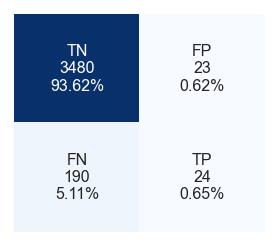

In [115]:
get_confusion(y_val, y_pr_gbc_val)

In [17]:
metrics = pd.read_csv("data/metrics.csv")
metrics

Unnamed: 0  Accuracy  F1 Score    Recall  Precision  \
0       Multinomial Naive Bayes  0.942696  0.009302  0.004673   1.000000   
1                 Random Forest  0.942696  0.190114  0.116822   0.510204   
2           Logistic Regression  0.944310  0.200772  0.121495   0.577778   
3        Support Vector Machine  0.939198  0.270968  0.196262   0.437500   
4           AdaBoost Classifier  0.940543  0.270627  0.191589   0.460674   
5  Gradient Boosting Classifier  0.941351  0.148438  0.088785   0.452381   

     PR AUC  
0  0.176758  
1  0.336623  
2  0.355640  
3  0.325087  
4  0.293496  
5  0.346358

# Class Imbalance

## Resampling Methods

### Random Under Sampler

In [19]:
metrics2 = pd.read_csv("data/metrics2.csv")
metrics2

Unnamed: 0  Accuracy  F1 Score    Recall  Precision  \
0       RUS Multinomial Naive Bayes  0.717514  0.248927  0.813084   0.146959   
1                 RUS Random Forest  0.784235  0.297723  0.794393   0.183190   
2           RUS Logistic Regression  0.834813  0.350951  0.775701   0.226776   
3        RUS Support Vector Machine  0.788270  0.299199  0.785047   0.184818   
4           RUS AdaBoost Classifier  0.793651  0.291782  0.738318   0.181818   
5  RUS Gradient Boosting Classifier  0.704600  0.247945  0.845794   0.145265   

     PR AUC  
0  0.324079  
1  0.321408  
2  0.328700  
3  0.298514  
4  0.233532  
5  0.317836

### Condensed Mearest Neighbor

In [20]:
metrics3 = pd.read_csv("data/metrics3.csv")
metrics3

Unnamed: 0  Accuracy  F1 Score    Recall  Precision  \
0       CNN Multinomial Naive Bayes  0.868173  0.321330  0.542056   0.228346   
1                 CNN Random Forest  0.889965  0.363919  0.546729   0.272727   
2           CNN Logistic Regression  0.890234  0.379939  0.584112   0.281532   
3        CNN Support Vector Machine  0.842884  0.312941  0.621495   0.209119   
4           CNN AdaBoost Classifier  0.808717  0.269270  0.612150   0.172596   
5  CNN Gradient Boosting Classifier  0.887813  0.378539  0.593458   0.277899   

     PR AUC  
0  0.272232  
1  0.313296  
2  0.320777  
3  0.247722  
4  0.176851  
5  0.301078

### SMOTE-ENN

In [21]:
metrics4 = pd.read_csv("data/metrics4.csv")
metrics4

Unnamed: 0  Accuracy  F1 Score    Recall  \
0       Sm-ENN Multinomial Naive Bayes  0.799839  0.274854  0.658879   
1                 Sm-ENNR andom Forest  0.924939  0.400000  0.434579   
2           Sm-ENN Logistic Regression  0.799839  0.274854  0.658879   
3        Sm-ENN Support Vector Machine  0.887544  0.354938  0.537383   
4           Sm-ENN AdaBoost Classifier  0.808717  0.269270  0.612150   
5  Sm-ENN Gradient Boosting Classifier  0.882701  0.368116  0.593458   

   Precision    PR AUC  
0   0.173645  0.297206  
1   0.370518  0.317766  
2   0.173645  0.313569  
3   0.264977  0.292743  
4   0.172596  0.276939  
5   0.266807  0.318589

## Additional Datasets

### Aristotle University Dataset

In [22]:
df = pd.read_csv('data/hatespeechtwitter.csv')
df.head()

tweet_id maj_label
0  849667487180259329   abusive
1  850490912954351616   abusive
2  848791766853668864   abusive
3  848306464892604416   abusive
4  850010509969465344    normal

In [23]:
df.columns = ['id', 'label']
df.label.value_counts()

normal     52835
spam       13404
abusive    10122
hateful     3635
Name: label, dtype: int64

In [24]:
df_hateful = df[df['label']=='hateful']
df_abusive = df[df['label']=='abusive']
df_neutral = df[df['label']=='normal']


In [25]:
hate_ids = group_list(list(df_hateful.id))
len(hate_ids)

37

In [26]:
abusive_ids = group_list(list(df_abusive.id))
len(abusive_ids)

102

In [27]:
neutral_ids = group_list(list(df_neutral.id))
len(neutral_ids)

529

### Twitter API

In [33]:
url = "https://api.twitter.com/2/tweets?ids=847661947159891972,847799130277675008,848933211375779840&tweet.fields=created_at,entities,geo,id,public_metrics,text&user.fields=description,entities,id,location,name,public_metrics,username"
payload={}
headers = {'Authorization': 'Bearer ' + keys['bearer_token'], 'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}
r = requests.request("GET", url, headers=headers, data=payload)
data = r.json()

In [34]:
df_hate = tweets_request(hate_ids)
df_hate.head(10)

100%|██████████| 37/37 [00:21<00:00,  1.70it/s]


text                  id  \
0  I hate er chase because if the Bitch that work...  850433664890544128   
1  RT @nyctophil3: Pineapples do not belong on pi...  850100742035836929   
2  Niggas keep talking about women wearing weave ...  847804507367100416   
3  @vappywave idiot that's not gonna work. you go...  850090319165050880   
4  RT @ayevonnn: bruh i fucking hate people like ...  848686686930382848   
5  RT @mattmfm: I'm really fucking sick of watchi...  850380636300820480   
6  @JayFoee_ just another dumbass bronco fan swea...  847652946217009155   
7  RT @THESLUMPGOD: I Sampled Jaws \n\nPull Up Wi...  848835698006401024   
8  RT @arianam0lina: if you litter you're a bitch...  850215875680522240   
9  RT @cybeque: Don't take out the anger of being...  849922895132459008   

                 created_at  \
0  2017-04-07T19:42:40.000Z   
1  2017-04-06T21:39:45.000Z   
2  2017-03-31T13:35:20.000Z   
3  2017-04-06T20:58:20.000Z   
4  2017-04-03T00:00:48.000Z   
5  2017-04-07T16:11:57.000Z   
6  2017-03-31T03:33:05.000Z   
7  2017-04-03T09:52:55.000Z   
8  2017-04-07T05:17:15.000Z   
9  2017-04-06T09:53:03.000Z   

                                      public_metrics  \
0  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
1  {'retweet_count': 5, 'reply_count': 0, 'like_c...   
2  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
3  {'retweet_count': 0, 'reply_count': 1, 'like_c...   
4  {'retweet_count': 5, 'reply_count': 0, 'like_c...   
5  {'retweet_count': 912, 'reply_count': 0, 'like...   
6  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
7  {'retweet_count': 6118, 'reply_count': 0, 'lik...   
8  {'retweet_count': 19, 'reply_count': 0, 'like_...   
9  {'retweet_count': 2, 'reply_count': 0, 'like_c...   

                                            entities  geo  
0                                                NaN  NaN  
1  {'mentions': [{'start': 3, 'end': 14, 'usernam...  NaN  
2                                                NaN  NaN  
3  {'mentions': [{'start': 0, 'end': 10, 'usernam...  NaN  
4  {'urls': [{'start': 53, 'end': 76, 'url': 'htt...  NaN  
5  {'mentions': [{'start': 3, 'end': 11, 'usernam...  NaN  
6                                                NaN  NaN  
7  {'mentions': [{'start': 3, 'end': 15, 'usernam...  NaN  
8  {'mentions': [{'start': 3, 'end': 16, 'usernam...  NaN  
9  {'mentions': [{'start': 3, 'end': 11, 'usernam...  NaN

In [35]:
df_1 = pickle.load(open("pickle/aristotle_hate.pickle", "rb"))
df_1['target'] = 1
preprocess_tweets(df_1, 'text')
df_1 = df_1[['text', 'target']]
df_1.head()

text  target
0  [hate, chase, bitch, work, shes, literally, evil]       1
1   [pineapples, belong, pizza, yall, niggas, nasty]       1
2  [niggas, talk, women, wear, weave, sick, bitch...       1
3  [idiot, thats, gonna, work, gotta, flame, stic...       1
4                   [bruh, fuck, hate, people, like]       1

### University of Copenhagen Dataset

In [28]:
df2 = pd.read_csv('data/NAACL_SRW_2016.csv')
df2.columns = ['id', 'label']

In [29]:
df2.label.value_counts()

none      11559
sexism     3378
racism     1969
Name: label, dtype: int64

In [ ]:
racsex_id = group_list(list(df_racsex.id))
df_rac_sex = tweets_request(racsex_id)

In [36]:
df_2 = pickle.load(open("pickle/copenhagen_2.pickle", "rb"))
df_2['target'] = 1
preprocess_tweets(df_2, 'text')
df_2 = df_2[['text', 'target']]
df_2.head()

text  target
0      [drasko, didnt, cook, half, bird, idiot, mkr]       1
1                     [hopefully, cook, drasko, mkr]       1
2  [course, bear, serbiayoure, fuck, serbian, fil...       1
3  [girls, equivalent, irritate, asian, girls, co...       1
4          [youre, tiny, bite, racist, racist, dick]       1

## HASOC 2019 and 2020 Dataset

In [30]:
english = pd.read_csv("data/english_dataset.tsv", delimiter="\t")
df_3 = english[english['task_2'] == 'HATE']
df_3['target'] = 1
preprocess_tweets(df_3, 'text')
df_3 = df_3[['text', 'target']]
df_3.head()

text  target
1   [remember, clearly, admit, treason, trumpisatr...       1
11    [dont, know, compulsive, liar, trumpisatraitor]       1
23  [shameonicc, icc, dhonis, gloves, plan, world,...       1
27  [disgust, dont, change, culture, come, vet, pr...       1
34  [retire, nfl, players, dont, suffer, cte, pool...       1

In [31]:
df_4 = pd.read_csv("data/labeled_data.csv", index_col=0)
df_4 = df_4.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
df_4.columns = ['target', 'text']
df_4 = df_4.replace({'target': {1: 0, 2: 0, 0: 1}})
preprocess_tweets(df_4, 'text')
df_4 = df_4[['target', 'text']]
df_4.head()

target                                               text
0       0  [woman, shouldnt, complain, clean, house, man,...
1       0  [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...
2       0          [dawg, fuck, bitch, start, confuse, shit]
3       0                               [look, like, tranny]
4       0             [shit, hear, true, faker, bitch, tell]

In [1]:
df_combined = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)
df_combined

NameError: name 'pd' is not defined

In [38]:
df_combined.target.value_counts()

0    23353
1     7043
Name: target, dtype: int64

## Train-Validation-Test Split

In [39]:
hate2 = df_combined[df_combined.target == 1]
non_hate2 = df_combined[df_combined.target == 0]

X_h2 = hate2.text
y_h2 = hate2.target
X_nh2 = non_hate2.text
y_nh2 = non_hate2.target

X_h_tr2, X_h_val2, y_h_tr2, y_h_val2 = train_test_split(X_h2, y_h2, test_size=0.25, random_state=42)
X_h_val2, X_h_tt2, y_h_val2, y_h_tt2 = train_test_split(X_h_val2, y_h_val2, test_size=0.4, random_state=42)
X_nh_tr2, X_nh_val2, y_nh_tr2, y_nh_val2 = train_test_split(X_nh2, y_nh2, test_size=0.25, random_state=42)
X_nh_val2, X_nh_tt2, y_nh_val2, y_nh_tt2 = train_test_split(X_nh_val2, y_nh_val2, test_size=0.4, random_state=42)

X_tr2 = pd.concat((X_h_tr2, X_nh_tr2), ignore_index=True)
y_tr2 = pd.concat((y_h_tr2, y_nh_tr2), ignore_index=True)
train2 = pd.concat([X_tr2, y_tr2], axis=1)
train2.text = train2.text.apply(lambda x: str(x)[1:-1]) 
train2.head()

X_val2 = pd.concat((X_h_val2, X_nh_val2), ignore_index=True)
y_val2 = pd.concat((y_h_val2, y_nh_val2), ignore_index=True)
val2 = pd.concat([X_val2, y_val2], axis=1)
val2.text = val2.text.apply(lambda x: str(x)[1:-1]) 
val2.head()

text  target  \
0  [kawhi, leonard, smh, wow, gonna, leak, nvm, i...       1   
1  [close, shop, feminism, roadblock, egalitarian...       1   
2              [mkr, wish, kat, sudden, death, stop]       1   
3                         [sexist, stand, feminists]       1   
4  [think, exact, word, know, carry, passport, mo...       1   

                                              tweet2  
0  'kawhi', 'leonard', 'smh', 'wow', 'gonna', 'le...  
1  'close', 'shop', 'feminism', 'roadblock', 'ega...  
2    'mkr', 'wish', 'kat', 'sudden', 'death', 'stop'  
3                     'sexist', 'stand', 'feminists'  
4  'think', 'exact', 'word', 'know', 'carry', 'pa...

text  target  \
0                 [america, white, trash, americans]       1   
1  [literally, eat, asshole, live, actually, fagg...       1   
2  [snipe, youre, fuck, faggot, fuck, hope, snipe...       1   
3  [goldbar, dumb, bitch, dad, wouldnt, pick, doe...       1   
4  [bump, bitch, file, sexual, harassment, work, ...       1   

                                              tweet2  
0           'america', 'white', 'trash', 'americans'  
1  'literally', 'eat', 'asshole', 'live', 'actual...  
2  'snipe', 'youre', 'fuck', 'faggot', 'fuck', 'h...  
3  'goldbar', 'dumb', 'bitch', 'dad', 'wouldnt', ...  
4  'bump', 'bitch', 'file', 'sexual', 'harassment...

In [40]:
X_tr2 = train2.tweet2
X_val2 = val2.tweet2
y_tr2 = train2.target
y_val2 = val2.target
vec = TfidfVectorizer()
tfidf_tr2 = vec.fit_transform(X_tr2)
tfidf_val2 = vec.transform(X_val2)

Train Accuracy:  0.896473065450079
Val Accuracy:  0.8646633033559992
Train F1:  0.71380063060878
Val F1:  0.5927392739273927
Train ROC-AUC:  0.9420282457433199
Val ROC-AUC:  0.8989698494364138
Train Recall:  0.5571753123816736
Vali Recall:  0.4251893939393939
Train Precision:  0.992914979757085
Val Precision:  0.9782135076252724
Train PR-AUC:  0.9050888424880698
Val PR-AUC:  0.8279656682191673


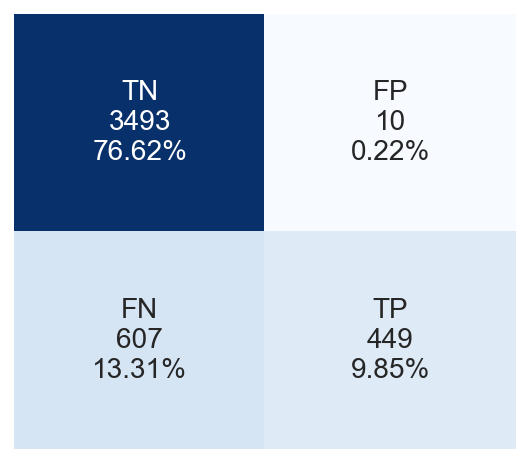

In [41]:
nb2 = MultinomialNB().fit(tfidf_tr2, y_tr2)
y_pr_nb_tr2 = nb2.predict(tfidf_tr2)
y_pr_nb_val2 = nb2.predict(tfidf_val2)
get_metrics(tfidf_tr2, y_tr2, tfidf_val2, y_val2, y_pr_nb_tr2, y_pr_nb_val2, nb2)

Train Accuracy:  0.9979382347780312
Val Accuracy:  0.9072164948453608
Train F1:  0.9955521907826252
Val F1:  0.7774855339295108
Train ROC-AUC:  0.9998290111352255
Val ROC-AUC:  0.9392401210218082
Train Recall:  0.9958349110185536
Vali Recall:  0.6998106060606061
Train Precision:  0.9952696310312205
Val Precision:  0.8745562130177514
Train PR-AUC:  0.9995072468318593
Val PR-AUC:  0.8802870640194286


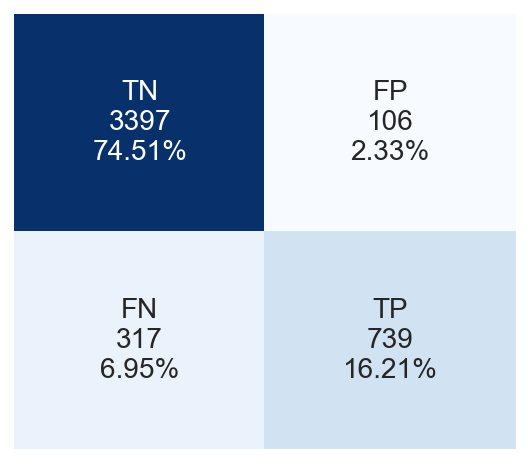

In [42]:
rf2 = RandomForestClassifier(n_estimators=100).fit(tfidf_tr2, y_tr2)
y_pr_rf_tr2 = rf2.predict(tfidf_tr2)
y_pr_rf_val2 = rf2.predict(tfidf_val2)
get_metrics(tfidf_tr2, y_tr2, tfidf_val2, y_val2, y_pr_rf_tr2, y_pr_rf_val2, rf2)

Train Accuracy:  0.9408229513949816
Val Accuracy:  0.9098486510199605
Train F1:  0.8583132023947064
Val F1:  0.7767517653449212
Train ROC-AUC:  0.9697492182053568
Val ROC-AUC:  0.9468300709781226
Train Recall:  0.7735706171904582
Vali Recall:  0.6770833333333334
Train Precision:  0.9639065817409767
Val Precision:  0.910828025477707
Train PR-AUC:  0.9460571822479237
Val PR-AUC:  0.893682368006331


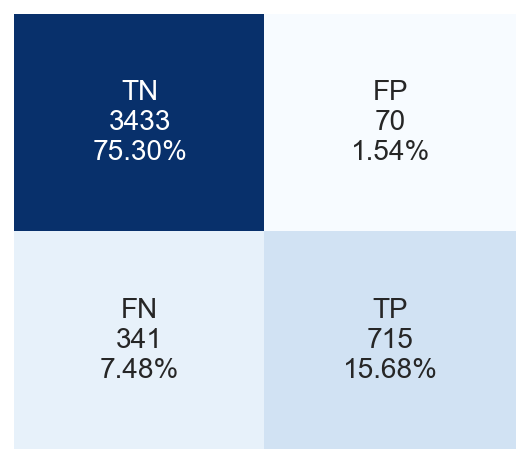

In [43]:
log2 = LogisticRegression().fit(tfidf_tr2, y_tr2)
y_pr_log_tr2 = log2.predict(tfidf_tr2)
y_pr_log_val2 = log2.predict(tfidf_val2)
get_metrics(tfidf_tr2, y_tr2, tfidf_val2, y_val2, y_pr_log_tr2, y_pr_log_val2, log2)

In [47]:
svc2 = svm.LinearSVC(random_state=42).fit(tfidf_tr2, y_tr2)
y_pr_svc_tr2 = svc2.predict(tfidf_tr2)
y_pr_svc_val2 = svc2.predict(tfidf_val2)
get_metriks_2(tfidf_tr2, y_tr2, tfidf_val2, y_val2, y_pr_svc_tr2, y_pr_svc_val2, svc2)

Train Accuracy:  0.975302684681523
Val Accuracy:  0.9080938802368941
Train F1:  0.9448309652131308
Val F1:  0.7867684478371502
Train Recall:  0.9127224536160545
Val Recall:  0.7320075757575758
Train Precision:  0.9792809262644728
Val Precision:  0.8503850385038504
Train PR-AUC:  0.9833214198823396
Val PR-AUC:  0.886307089105503


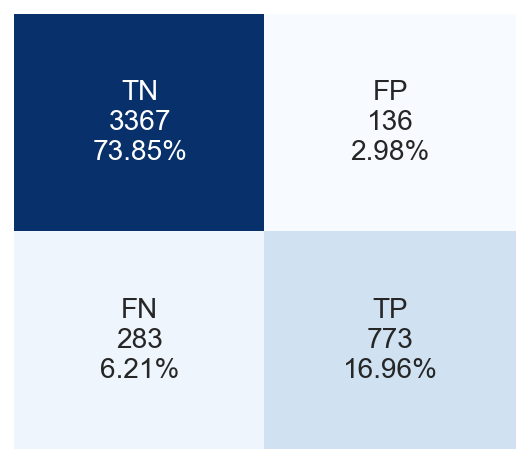

In [49]:
get_confusion(y_val2, y_pr_svc_val2)

Train Accuracy:  0.8970872082821547
Val Accuracy:  0.88528186005703
Train F1:  0.7378185069289227
Val F1:  0.7076579094466182
Train ROC-AUC:  0.9614077170134937
Val ROC-AUC:  0.9356621543006427
Train Recall:  0.6249526694433927
Vali Recall:  0.5994318181818182
Train Precision:  0.9004364429896344
Val Precision:  0.8635743519781719
Train PR-AUC:  0.8875789493400517
Val PR-AUC:  0.8509081977851588


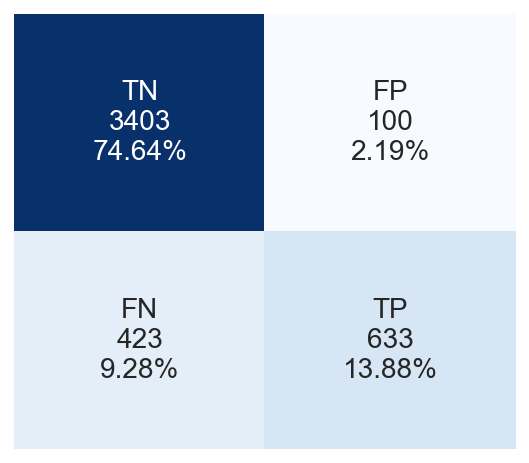

In [44]:
abc2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
    ).fit(tfidf_tr2, y_tr2)
y_pr_ada_tr2 = abc2.predict(tfidf_tr2)
y_pr_ada_val2 = abc2.predict(tfidf_val2)
get_metrics(tfidf_tr2, y_tr2, tfidf_val2, y_val2, y_pr_ada_tr2, y_pr_ada_val2, abc2)

Train Accuracy:  0.877259168275136
Val Accuracy:  0.874533889010748
Train F1:  0.6440203562340967
Val F1:  0.6333333333333332
Train ROC-AUC:  0.93235178720225
Val ROC-AUC:  0.9154036799626293
Train Recall:  0.4791745550927679
Vali Recall:  0.4678030303030303
Train Precision:  0.9817688130333592
Val Precision:  0.9801587301587301
Train PR-AUC:  0.8194371456919428
Val PR-AUC:  0.7886719753171262


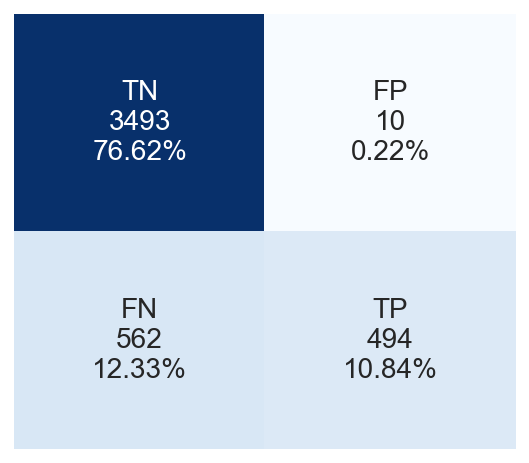

In [45]:

gbc2 = GradientBoostingClassifier().fit(tfidf_tr2, y_tr2)
y_pr_gbc_tr2 = gbc2.predict(tfidf_tr2)
y_pr_gbc_val2 = gbc2.predict(tfidf_val2)
get_metrics(tfidf_tr2, y_tr2, tfidf_val2, y_val2, y_pr_gbc_tr2, y_pr_gbc_val2, gbc2)